In [11]:
#### Part 03 of learning KNN. Check knn101 and knn102 for previous part ####
# Here I am combining, (Setosa and Versicolor) vs Virginica
# 1. First use weight + metrics 

In [213]:
import sys
print("Python version:", sys.version)

import sklearn
print("scikit-learn version:", sklearn.__version__)

import platform
print("Operating System:", platform.system())
print("OS version:", platform.version())
print("Processor:", platform.processor())

Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
scikit-learn version: 1.5.1
Operating System: Darwin
OS version: Darwin Kernel Version 22.6.0: Wed Jul  5 22:21:53 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T6020
Processor: arm


In [215]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
iris = load_iris()

df = pd.DataFrame(iris.data, columns = iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [217]:
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [219]:
df['flower_name'] = df.target.apply(lambda x: iris.target_names[x])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,flower_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [221]:
# Preparing an imbalance dataset of (Setosa vs Versicolor) and only Virginica
# For Virginica we will keep 0
# For Setosa vs Versicolor we will keep 1

# Split the data and create independent DataFrames
df_setosa = df[:50].copy()
df_versicolor = df[50:100].copy()
df_virginica = df[100:].copy()

df_setosa_and_versicolor = df[:100].copy()

# Modify the 'target' column for Setosa and Versicolor to be 1.
df_setosa_and_versicolor['target'] = 1
df_setosa_and_versicolor['flower_name'] = "Setosa and Versicolor" 

df_virginica['target'] = 0

df_combined_s_ve_and_vi = pd.concat([df_setosa_and_versicolor, df_virginica], ignore_index=True)
# Now we have df_combined, that has binary classifer of Setosa and (Versicolor and Virginica)

In [223]:
df_combined_s_ve_and_vi

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,flower_name
0,5.1,3.5,1.4,0.2,1,Setosa and Versicolor
1,4.9,3.0,1.4,0.2,1,Setosa and Versicolor
2,4.7,3.2,1.3,0.2,1,Setosa and Versicolor
3,4.6,3.1,1.5,0.2,1,Setosa and Versicolor
4,5.0,3.6,1.4,0.2,1,Setosa and Versicolor
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,virginica
146,6.3,2.5,5.0,1.9,0,virginica
147,6.5,3.0,5.2,2.0,0,virginica
148,6.2,3.4,5.4,2.3,0,virginica


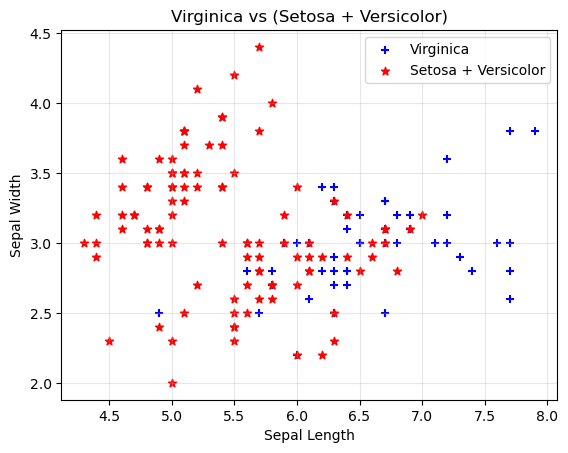

In [225]:
# Scatter plot for Virginica vs (Setosa + Versicolor)
plt.scatter(df_virginica['sepal length (cm)'], df_virginica['sepal width (cm)'], color='blue', label='Virginica', marker = "+")
plt.scatter(df_setosa_and_versicolor['sepal length (cm)'], df_setosa_and_versicolor['sepal width (cm)'], color='red', label='Setosa + Versicolor', marker = "*")
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Virginica vs (Setosa + Versicolor)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [227]:
def calculateTSSFromPostiveAndNegative(true_positive, true_negative, false_positive, false_negative):
    number_of_positives = true_positive + false_negative
    number_of_negatives = true_negative + false_positive

    return ((true_positive * true_negative) - (false_positive * false_negative)) / (number_of_positives * number_of_negatives)

# Method to calculate, TSS
# TSS = ((TP * TN) - (FP * FN))/((TP + FN)*(TN+FP))
def calculateTSS(array):
    true_positive = array[0][0]
    false_positive = array[0][1]
    false_negative = array[1][0]
    true_negative = array[1][1]

    number_of_positives = true_positive + false_negative
    number_of_negatives = true_negative + false_positive

    return ((true_positive * true_negative) - (false_positive * false_negative)) / (number_of_positives * number_of_negatives)

In [373]:
# We will optimize the weights and metrics as hyperparameters to enhance the model's performance for this imbalanced Data
# Virginica vs (Setosa + Versicolor)

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

def leave_one_out_validation(k_neighbors, df, weights=None, metric=None, p=None):
    if weights is None:
        weights = 'uniform'  
    if metric is None:
        metric = 'minkowski' 
    if p is None:
        p = 2 

    loo = LeaveOneOut()
    
    # Aggregating TP, TN, FP, and FN.
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    accuracy = []
    
    X = df.drop(['target', 'flower_name'], axis='columns')
    Y = df['target']

    print (weights)
    print (metric)
    print (p)

    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        knn = KNeighborsClassifier(
            n_neighbors=k_neighbors,
            weights=weights,
            metric=metric,
            p=p
        )
        knn.fit(X_train, Y_train)
        
        Y_pred = knn.predict(X_test)
    
        # Cannot computer TSS, because conf_matrix only accounts for one sample at a time for LOO, 
        # so, depending on true lable of test sample, one row or one column in confusion matrix can remain entirely zero,
        # So, the dividing by zeroo occurs in TSS 
        conf_matrix = confusion_matrix(Y_test, Y_pred, labels=knn.classes_)  # labels ensure consistency in TSS
    
        # print(conf_matrix)
        
        true_positive += conf_matrix[0][0]
        true_negative += conf_matrix[1][1]
        false_positive += conf_matrix[0][1]
        false_negative += conf_matrix[1][0]
        
        accuracy.append(knn.score(X_test, Y_test))
    
    tss = calculateTSSFromPostiveAndNegative(true_positive, true_negative, false_positive, false_negative)
    return tss
    

In [375]:
# LOO validation with no change in the imbalanced dataset
k = [1, 3, 5]
for i in k:
    tss = leave_one_out_validation(i, df_combined_s_ve_and_vi, 'uniform', 'manhattan', 2)
    print ("LOO test, Mean TSS for imbalanced dataset of Virginica vs (Setosa + Versicolor) for k = " + str(i) + " is: ", tss)


uniform
manhattan
2
LOO test, Mean TSS for imbalanced dataset of Virginica vs (Setosa + Versicolor) for k = 1 is:  0.899171549808042
uniform
manhattan
2
LOO test, Mean TSS for imbalanced dataset of Virginica vs (Setosa + Versicolor) for k = 3 is:  0.91
uniform
manhattan
2
LOO test, Mean TSS for imbalanced dataset of Virginica vs (Setosa + Versicolor) for k = 5 is:  0.88


In [253]:
# Normalize the data for all the sample.

from sklearn.preprocessing import MinMaxScaler

df_combined_s_ve_and_vi_copy = df_combined_s_ve_and_vi.copy()

# features to normalize
features_to_normalize = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

scaler = MinMaxScaler()

#normalize selected features
df_combined_s_ve_and_vi_copy[features_to_normalize] = scaler.fit_transform(df_combined_s_ve_and_vi_copy[features_to_normalize])

print(df_combined_s_ve_and_vi_copy.head())

k = [1, 3, 5]
for i in k:
    tss = leave_one_out_validation(i, df_combined_s_ve_and_vi_copy)
    print ("Mean TSS for imbalanced dataset after NORMALIZING all of the features of Virginica vs (Setosa + Versicolor) for k = " + str(i) + " is: ", tss)


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0           0.222222          0.625000           0.067797          0.041667   
1           0.166667          0.416667           0.067797          0.041667   
2           0.111111          0.500000           0.050847          0.041667   
3           0.083333          0.458333           0.084746          0.041667   
4           0.194444          0.666667           0.067797          0.041667   

   target            flower_name  
0       1  Setosa and Versicolor  
1       1  Setosa and Versicolor  
2       1  Setosa and Versicolor  
3       1  Setosa and Versicolor  
4       1  Setosa and Versicolor  
Mean TSS for imbalanced dataset after NORMALIZING all of the features of Virginica vs (Setosa + Versicolor) for k = 1 is:  0.8615567439096851
Mean TSS for imbalanced dataset after NORMALIZING all of the features of Virginica vs (Setosa + Versicolor) for k = 3 is:  0.899171549808042
Mean TSS for imbalanced dataset 

In [247]:
# Normalize the data based on the Virginca scale

from sklearn.preprocessing import MinMaxScaler

df_setosa_and_versicolor_copy = df_setosa_and_versicolor.copy()
df_virginica_copy = df_virginica.copy()

features_to_normalize = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

scaler = MinMaxScaler()

scaler.fit(df_virginica_copy[features_to_normalize]) 

df_setosa_and_versicolor_copy[features_to_normalize] = scaler.transform(df_setosa_and_versicolor_copy[features_to_normalize])

df_virginica_copy[features_to_normalize] = scaler.transform(df_virginica_copy[features_to_normalize])

df_combined_normalized_based_on_virginica = pd.concat([df_setosa_and_versicolor_copy, df_virginica_copy], ignore_index=True)

print(df_combined_normalized_based_on_virginica.head())

k = [1, 3, 5]
for i in k:
    tss = leave_one_out_validation(i, df_combined_normalized_based_on_virginica)
    print ("Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = " + str(i) + " is: ", tss)


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0           0.066667            0.8125          -1.291667         -1.090909   
1           0.000000            0.5000          -1.291667         -1.090909   
2          -0.066667            0.6250          -1.333333         -1.090909   
3          -0.100000            0.5625          -1.250000         -1.090909   
4           0.033333            0.8750          -1.291667         -1.090909   

   target            flower_name  
0       1  Setosa and Versicolor  
1       1  Setosa and Versicolor  
2       1  Setosa and Versicolor  
3       1  Setosa and Versicolor  
4       1  Setosa and Versicolor  
Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = 1 is:  0.8615567439096851
Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = 3 is:  0.88
Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = 5 is:  0.88


In [383]:
# Combination of Normalization all of the data and weights

from sklearn.preprocessing import MinMaxScaler

df_setosa_and_versicolor_copy = df_setosa_and_versicolor.copy()
df_virginica_copy = df_virginica.copy()

features_to_normalize = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

scaler = MinMaxScaler()

scaler.fit(df_virginica_copy[features_to_normalize]) 

df_setosa_and_versicolor_copy[features_to_normalize] = scaler.transform(df_setosa_and_versicolor_copy[features_to_normalize])

df_virginica_copy[features_to_normalize] = scaler.transform(df_virginica_copy[features_to_normalize])

df_combined_normalized_based_on_virginica = pd.concat([df_setosa_and_versicolor_copy, df_virginica_copy], ignore_index=True)

print(df_combined_normalized_based_on_virginica.head())

k = [1, 3, 5]
for i in k:
    tss = leave_one_out_validation(i, df_combined_normalized_based_on_virginica, "uniform", "minkowski", 2)  # Adding weights
    print ("Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = " + str(i) + " is: ", tss)


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0           0.066667            0.8125          -1.291667         -1.090909   
1           0.000000            0.5000          -1.291667         -1.090909   
2          -0.066667            0.6250          -1.333333         -1.090909   
3          -0.100000            0.5625          -1.250000         -1.090909   
4           0.033333            0.8750          -1.291667         -1.090909   

   target            flower_name  
0       1  Setosa and Versicolor  
1       1  Setosa and Versicolor  
2       1  Setosa and Versicolor  
3       1  Setosa and Versicolor  
4       1  Setosa and Versicolor  
uniform
minkowski
2
Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = 1 is:  0.9294807031723581
uniform
minkowski
2
Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = 3 is:  0.899171549808042
uniform
minkowski
2
Mean TSS for imbalanced dataset 

In [377]:
# COMBINATION of Normalize the data based on the Virginca scale + Weights

from sklearn.preprocessing import MinMaxScaler

df_setosa_and_versicolor_copy = df_setosa_and_versicolor.copy()
df_virginica_copy = df_virginica.copy()

features_to_normalize = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

scaler = MinMaxScaler()

scaler.fit(df_virginica_copy[features_to_normalize]) 

df_setosa_and_versicolor_copy[features_to_normalize] = scaler.transform(df_setosa_and_versicolor_copy[features_to_normalize])

df_virginica_copy[features_to_normalize] = scaler.transform(df_virginica_copy[features_to_normalize])

df_combined_normalized_based_on_virginica = pd.concat([df_setosa_and_versicolor_copy, df_virginica_copy], ignore_index=True)

print(df_combined_normalized_based_on_virginica.head())

k = [1, 3, 5]
for i in k:
    tss = leave_one_out_validation(i, df_combined_normalized_based_on_virginica, "uniform", "minkowski", 2)  # Adding weights
    print ("Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = " + str(i) + " is: ", tss)


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0           0.066667            0.8125          -1.291667         -1.090909   
1           0.000000            0.5000          -1.291667         -1.090909   
2          -0.066667            0.6250          -1.333333         -1.090909   
3          -0.100000            0.5625          -1.250000         -1.090909   
4           0.033333            0.8750          -1.291667         -1.090909   

   target            flower_name  
0       1  Setosa and Versicolor  
1       1  Setosa and Versicolor  
2       1  Setosa and Versicolor  
3       1  Setosa and Versicolor  
4       1  Setosa and Versicolor  
uniform
minkowski
2
Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = 1 is:  0.9294807031723581
uniform
minkowski
2
Mean TSS for imbalanced dataset after NORMALIZING features based on Virginica for k = 3 is:  0.899171549808042
uniform
minkowski
2
Mean TSS for imbalanced dataset 